# TMDB Box Office Prediction EDA + ML

![](https://cdn-images-1.medium.com/max/1200/1*vIR7iO-1GnY2xYxL6NiYkw.png)
[image-source](https://cdn-images-1.medium.com/max/1200/1*vIR7iO-1GnY2xYxL6NiYkw.png)

In a world... where movies made an estimated $41.7 billion in 2018, the film industry is more popular than ever. But what movies make the most money at the box office? How much does a director matter? Or the budget? For some movies, it's "You had me at 'Hello.'" For others, the trailer falls short of expectations and you think "What we have here is a failure to communicate."

In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

## *Kernel in progress, is continuously being updated and extended*

## Preparations - Prerequisities

![](https://images-na.ssl-images-amazon.com/images/I/91HTK796%2BML._SX425_.jpg)
[image-source](https://images-na.ssl-images-amazon.com/images/I/91HTK796%2BML._SX425_.jpg)

### Loading Libraries

In [167]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import gc

import warnings
warnings.filterwarnings("ignore")

['train.csv', 'sample_submission.csv', 'test.csv']


### Loading the data

In [168]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sub_df = pd.read_csv('../input/sample_submission.csv')

### Inspecting the train set

In [169]:
train_df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


We have a variaty of data, numerical, categorical and even lists of json formats.

In [170]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

### Check for NA values in trainset

In [171]:
train_df.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

## Exploratory Data Analysis

![](https://prod-discovery.edx-cdn.org/media/course/image/2102f79d-9a44-41e9-9d92-884bec46dc65-ff40350cad17.small.jpg)
[image-source](https://prod-discovery.edx-cdn.org/media/course/image/2102f79d-9a44-41e9-9d92-884bec46dc65-ff40350cad17.small.jpg)

In [172]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

So many columns and features to investigate, lets start by inspecting one by one each feature.

### Univariate Analysis

#### Revenue
Our target variable to be predicted

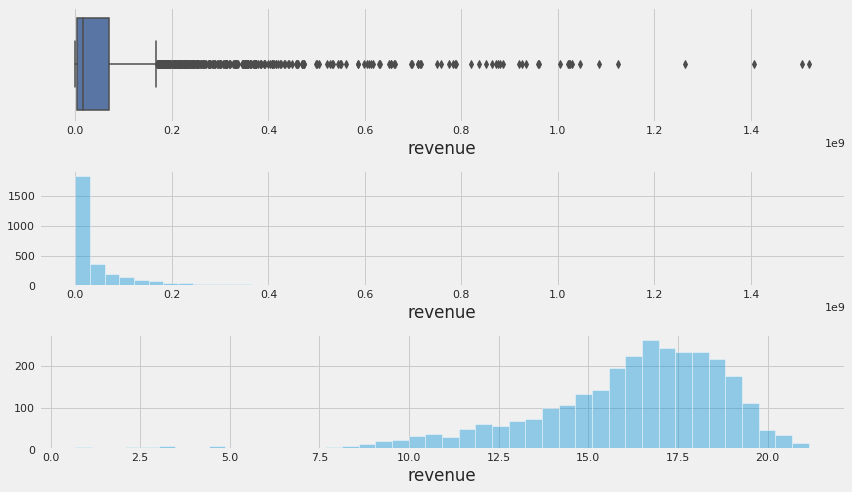

In [173]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train_df.revenue, ax = ax[0])
sns.distplot(a=train_df.revenue, kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.revenue), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_revenue"] = np.log1p(train_df.revenue)

#### Budget

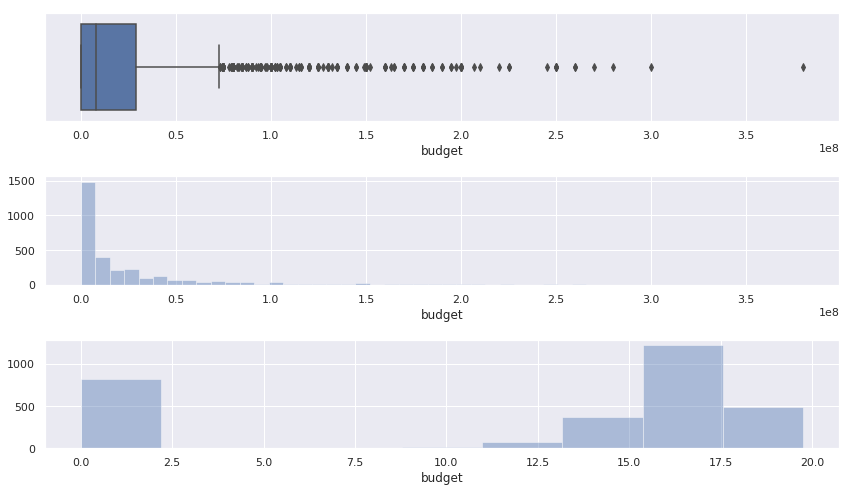

In [174]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train_df.budget, ax = ax[0])
sns.distplot(a=train_df.budget, kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.budget), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_budget"] = np.log1p(train_df.budget)
test_df["log_budget"] = np.log1p(test_df.budget)

#### Genres

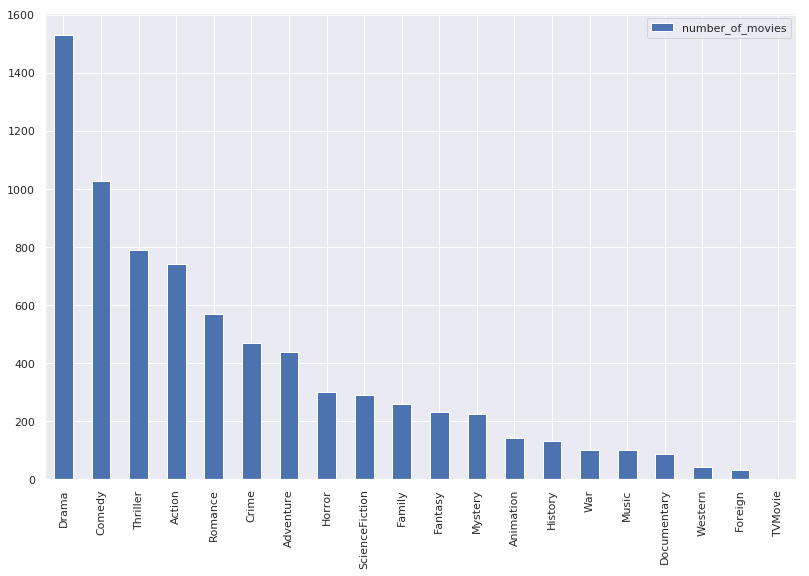

In [175]:
def genres_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace("name", "").replace("id", "").replace(":", "")
    ll = str1.split(",")[1::2]
    return ll

train_df["genres_processed"] = train_df.genres.apply(lambda elem: genres_preprocessing(elem))
test_df["genres_processed"] = test_df.genres.apply(lambda elem: genres_preprocessing(elem))

genres_dict = dict()

for genre in train_df["genres_processed"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
        else:
            genres_dict[elem] += 1


sns.set(rc={'figure.figsize':(12,8)})
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar()

#### Number of Genres

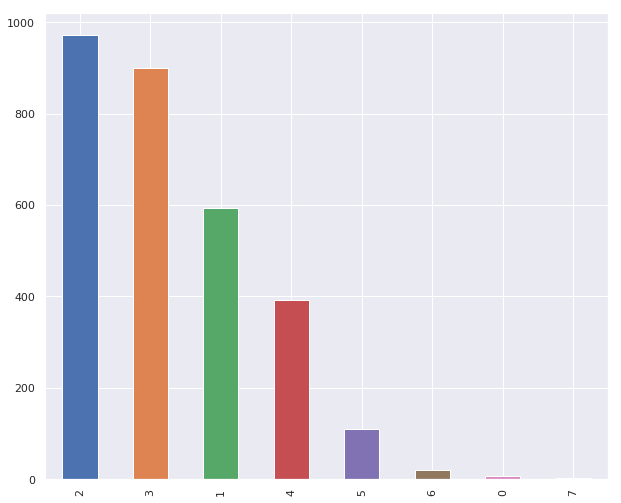

In [176]:
sns.set(rc={'figure.figsize':(9,8)})
train_df['num_genres'] = train_df['genres_processed'].apply(lambda x: len(x) if x != {} else 0)
test_df['num_genres'] = test_df['genres_processed'].apply(lambda x: len(x) if x != {} else 0)
train_df['num_genres'].value_counts().plot.bar()

#### isGenre, creating new feature
isDrama, isComedy etc.

In [177]:
genres_df.index.values
for g in genres_df.index.values:
    train_df['isGenre_' + g] = train_df['genres_processed'].apply(lambda x: 1 if g in x else 0)
    test_df['isGenre_' + g] = test_df['genres_processed'].apply(lambda x: 1 if g in x else 0)

In [178]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'log_revenue', 'log_budget', 'genres_processed', 'num_genres',
       'isGenre_Drama', 'isGenre_Comedy', 'isGenre_Thriller', 'isGenre_Action',
       'isGenre_Romance', 'isGenre_Crime', 'isGenre_Adventure',
       'isGenre_Horror', 'isGenre_ScienceFiction', 'isGenre_Family',
       'isGenre_Fantasy', 'isGenre_Mystery', 'isGenre_Animation',
       'isGenre_History', 'isGenre_War', 'isGenre_Music',
       'isGenre_Documentary', 'isGenre_Western', 'isGenre_Foreign',
       'isGenre_TVMovie'],
      dtype='object')

#### Original Language

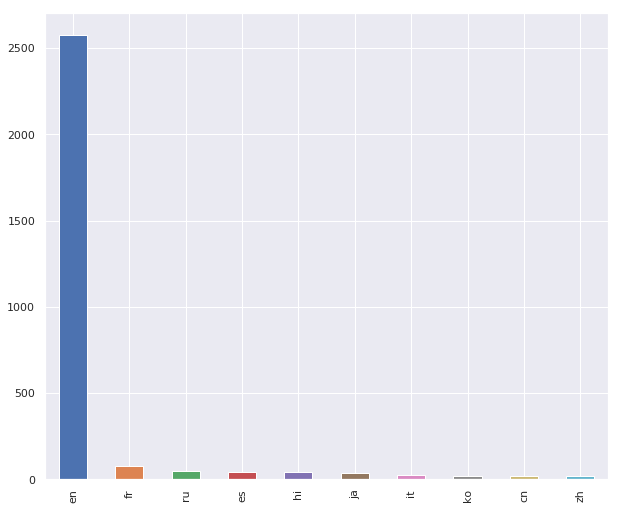

In [179]:
train_df.original_language.value_counts()[:10].plot.bar()

#### Production Companies

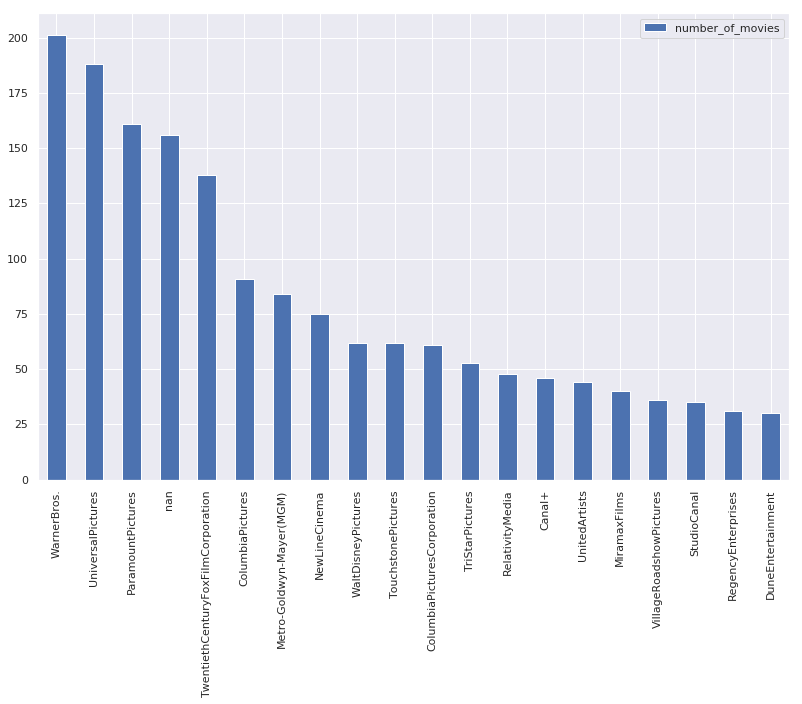

In [180]:
def production_companies_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("id", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_companies_processed"] = train_df.production_companies.apply(lambda elem: production_companies_preprocessing(elem))

production_companies_dict = dict()

for production_company in train_df["production_companies_processed"]:
    for elem in production_company:
        if elem not in production_companies_dict:
            production_companies_dict[elem] = 1
        else:
            production_companies_dict[elem] += 1


sns.set(rc={'figure.figsize':(12,8)})
production_companies_df = pd.DataFrame.from_dict(production_companies_dict, orient='index')
production_companies_df.columns = ["number_of_movies"]
production_companies_df = production_companies_df.sort_values(by="number_of_movies", ascending=False)
production_companies_df.head(20).plot.bar()

#### production_countries

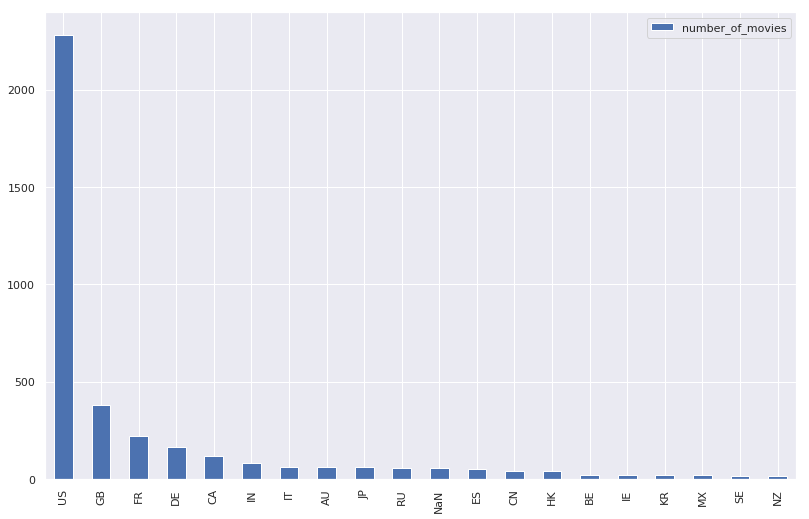

In [181]:
def production_countries_preprocessing(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("iso_3166_1", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

train_df["production_countries_processed"] = train_df.production_countries.fillna("NaN").apply(lambda elem: production_countries_preprocessing(elem))


production_countries_dict = dict()

for production_country in train_df["production_countries_processed"]:
    for elem in production_country:
        if elem not in production_countries_dict:
            production_countries_dict[elem] = 1
        else:
            production_countries_dict[elem] += 1



production_countries_df = pd.DataFrame.from_dict(production_countries_dict, orient='index')
production_countries_df.columns = ["number_of_movies"]
production_countries_df = production_countries_df.sort_values(by="number_of_movies", ascending=False)
production_countries_df.head(20).plot.bar()

#### popularity

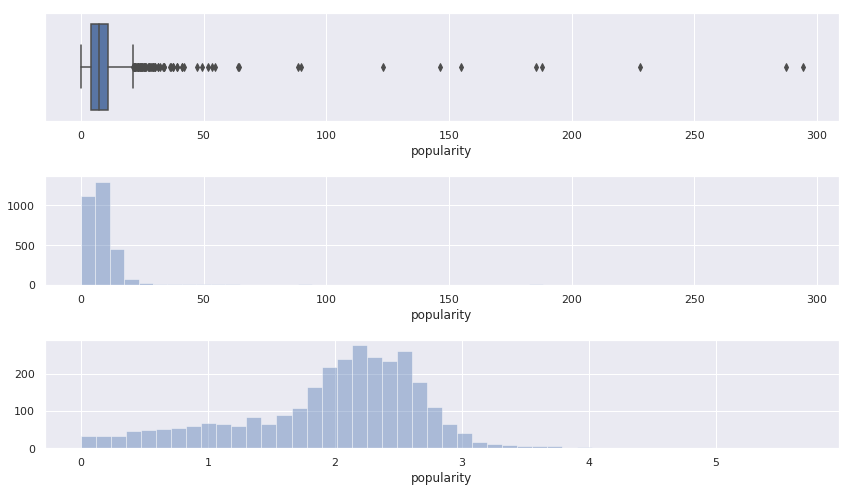

In [182]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.boxplot(x=train_df.popularity, ax = ax[0])
sns.distplot(a=train_df.popularity, kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.popularity), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_popularity"] = np.log1p(train_df.popularity)
test_df["log_popularity"] = np.log1p(test_df.popularity)

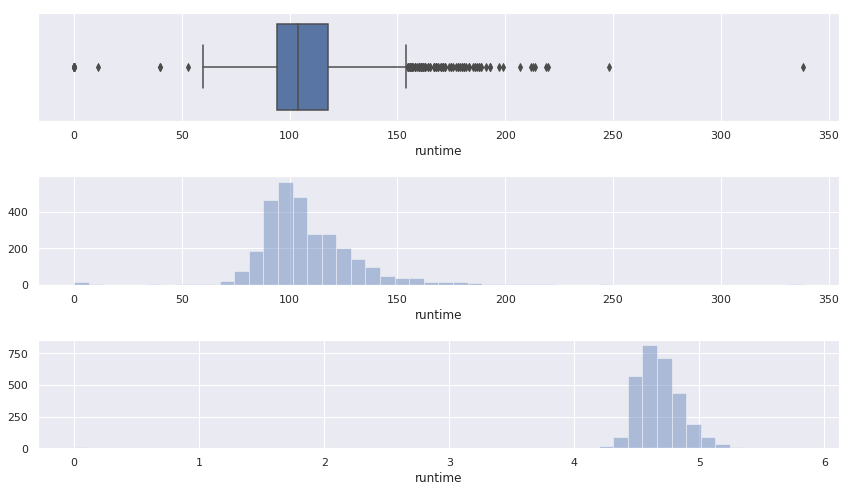

In [183]:
f, ax = plt.subplots(3, figsize=(12,7))
sns.boxplot(x=train_df.runtime, ax = ax[0])
sns.distplot(a=train_df.runtime.fillna(value=0), kde = False, ax = ax[1])
sns.distplot(a=np.log1p(train_df.runtime.fillna(value=1)), kde = False, ax = ax[2])
f.tight_layout()

train_df["log_runtime"] = np.log1p(train_df.runtime)
test_df["log_runtime"] = np.log1p(test_df.runtime)

In [184]:
from datetime import datetime


train_df['temp'] = train_df.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

train_df["month"] = train_df.temp.apply(lambda x: x.month)
train_df["year"] = train_df.temp.apply(lambda x: x.year)
train_df["day_of_week"] = train_df.temp.apply(lambda x: x.weekday()+1)

train_df = train_df.drop(['temp'], axis=1)

train_df[["release_date", "month", "year", "day_of_week"]].head()

,release_date,month,year,day_of_week
0,2/20/15,2,2015,5
1,8/6/04,8,2004,5
2,10/10/14,10,2014,5
3,3/9/12,3,2012,5
4,2/5/09,2,2009,4


#### Month of Release, which month has most of the releases

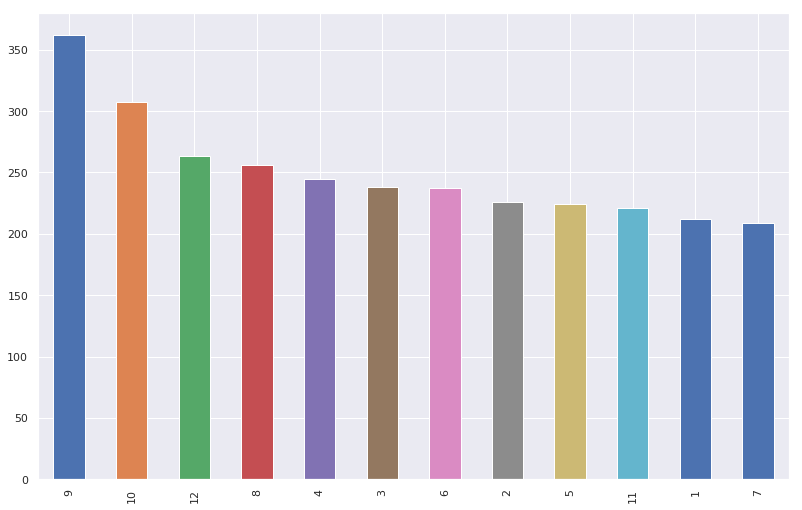

In [185]:
sns.set(rc={'figure.figsize':(12,8)})
train_df.month.value_counts().plot.bar()

#### Day of Release, which day of the week has most of the releases

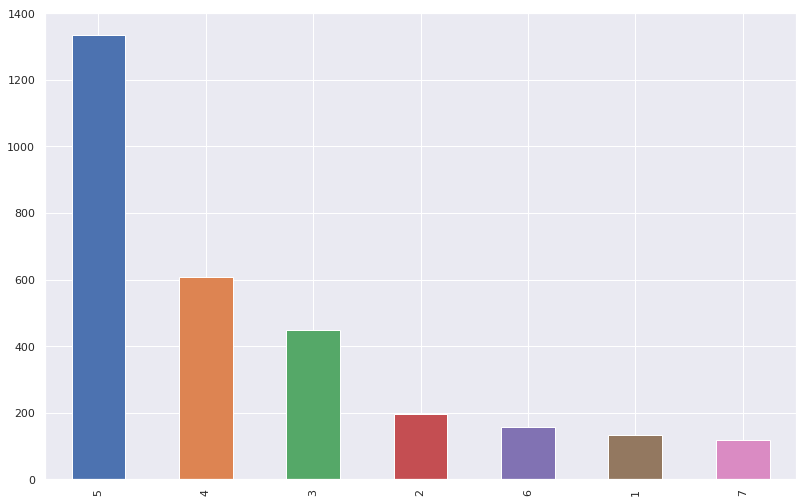

In [186]:
sns.set(rc={'figure.figsize':(12,8)})
train_df.day_of_week.value_counts().plot.bar()

#### Year of Release, which year has most of the releases

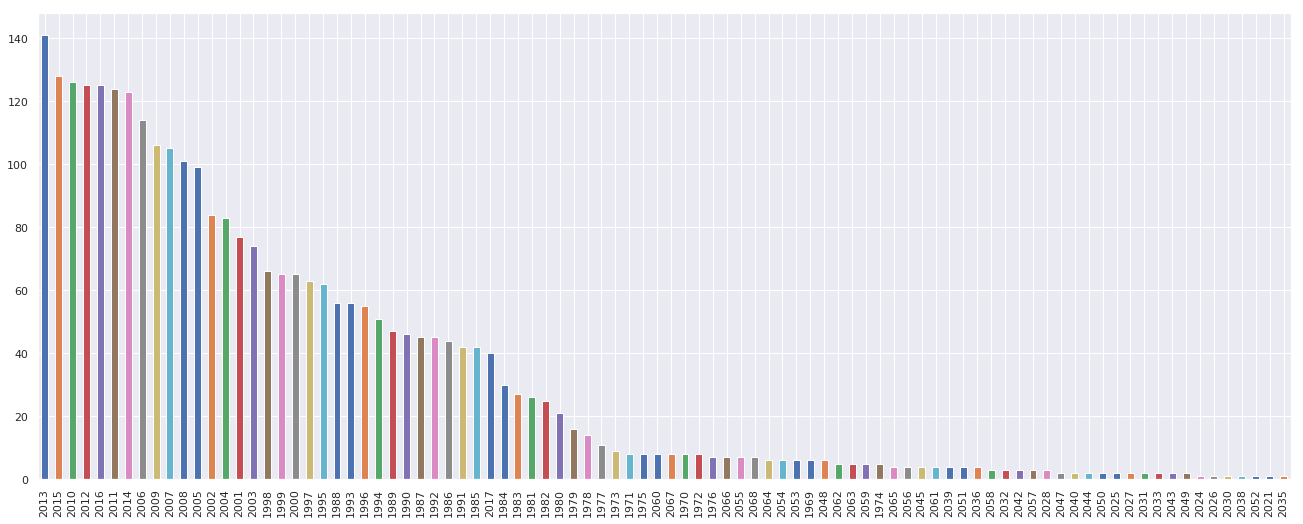

In [187]:
sns.set(rc={'figure.figsize':(20,8)})
train_df.year.value_counts().plot.bar()

### EDA - Bivariate Analysis

#### Bivariate Analysis for numerical features

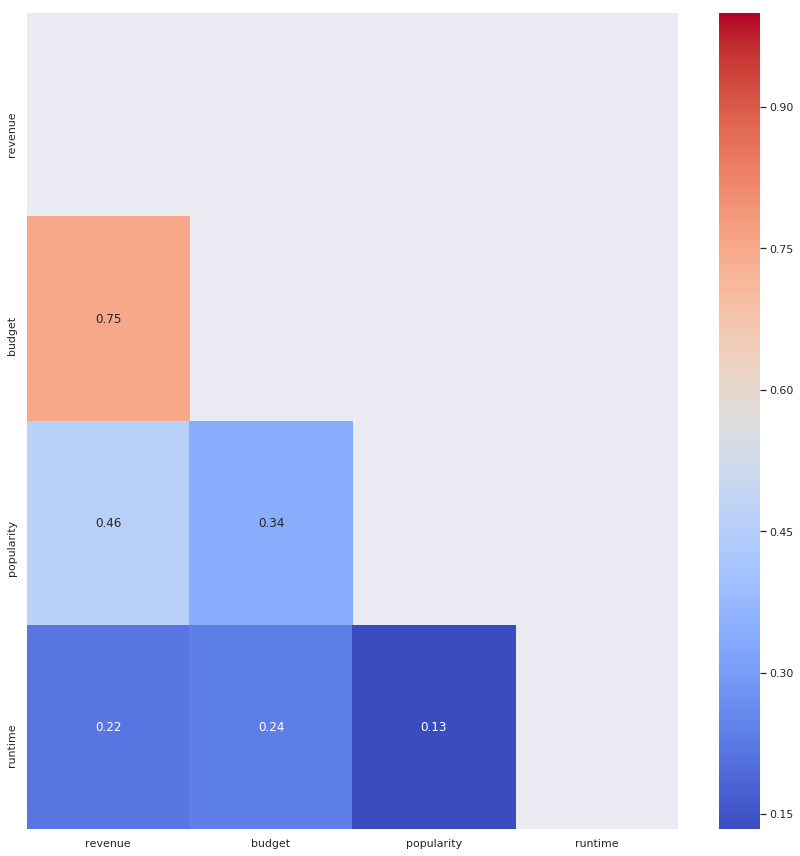

In [188]:
sns.set(rc={'figure.figsize':(13,14)})

# Compute the correlation matrix
corr = train_df[["revenue", "budget", "popularity", "runtime"]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

#### Bivariate Analysis for log-transformed numerical features

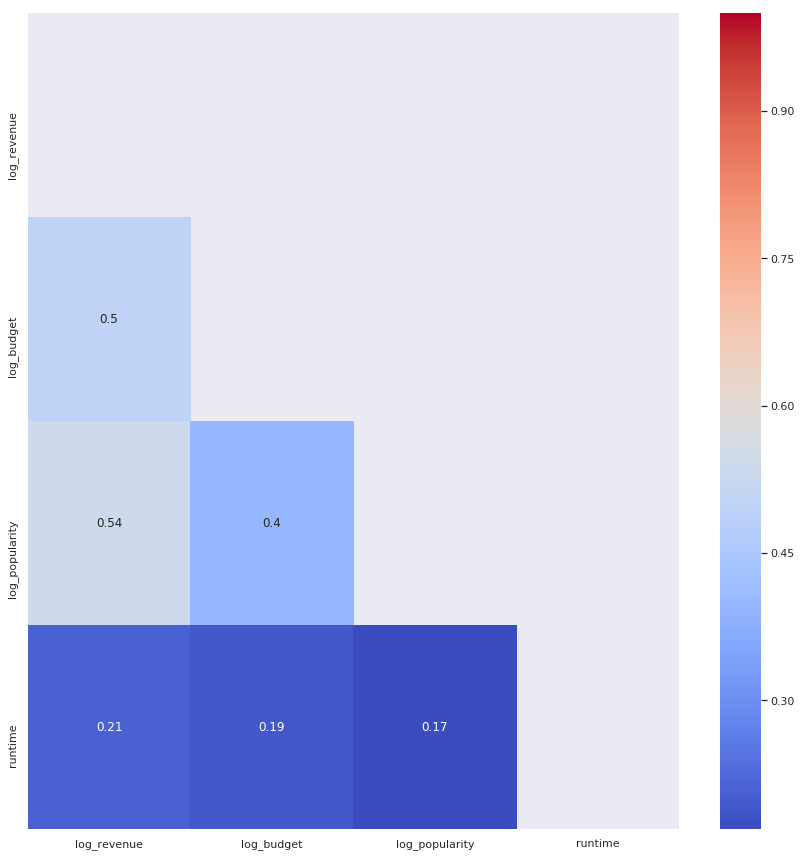

In [189]:
sns.set(rc={'figure.figsize':(13,14)})

# Compute the correlation matrix
corr = train_df[["log_revenue", "log_budget", "log_popularity", "runtime"]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            #fmt=".2f", 
            cmap='coolwarm')

### Bivariate Analysis and Feature Engineering

#### has_collection and revenue

0    2396
1     604
Name: has_collection, dtype: int64


Text(0.5, 1.0, 'Revenue for film with and without being in a collection')

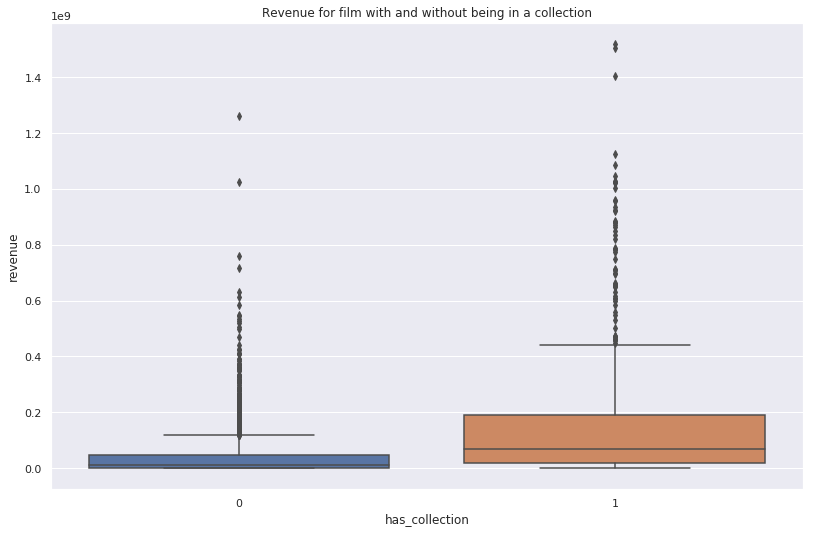

In [190]:
train_df['has_collection'] = [0 if pd.isnull(x) else 1 for x in train_df['belongs_to_collection']]
test_df['has_collection'] = [0 if pd.isnull(x) else 1 for x in test_df['belongs_to_collection']]
print(train_df['has_collection'].value_counts())

sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='has_collection', y='revenue', data=train_df)
plt.title('Revenue for film with and without being in a collection')

#### homepage and revenue

0    2054
1     946
Name: has_homepage, dtype: int64


Text(0.5, 1.0, 'Revenue for film with and without homepage')

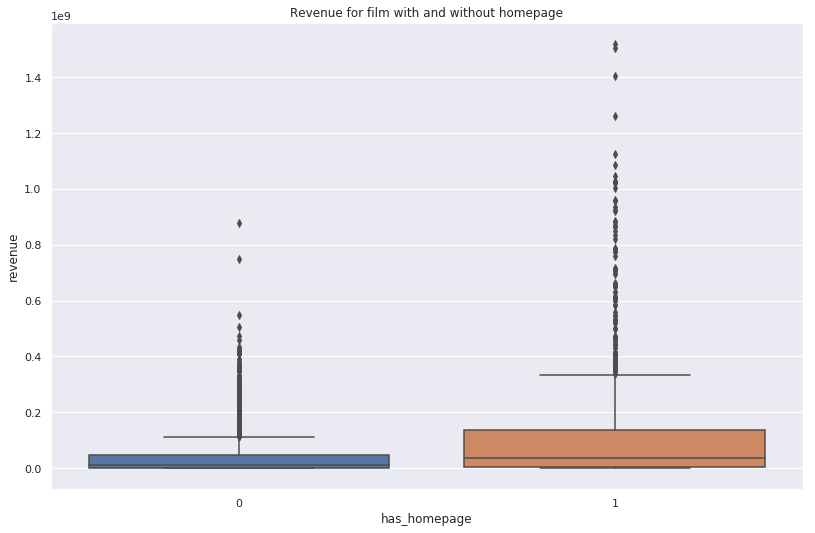

In [191]:
train_df['has_homepage'] = [0 if pd.isnull(x) else 1 for x in train_df['homepage']]
test_df['has_homepage'] = [0 if pd.isnull(x) else 1 for x in test_df['homepage']]
print(train_df['has_homepage'].value_counts())

sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='has_homepage', y='revenue', data=train_df)
plt.title('Revenue for film with and without homepage')

#### Number of Genres per movie and revenues

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: num_of_genres, dtype: int64


Text(0.5, 1.0, 'Revenues for films with multiple genres')

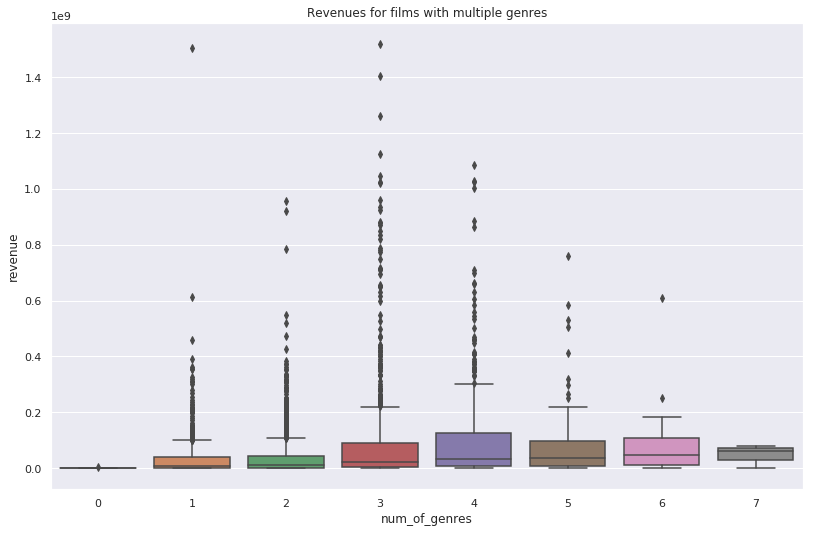

In [192]:
train_df["num_of_genres"] = train_df.genres_processed.apply(len)
print(train_df["num_of_genres"].value_counts())

sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='num_of_genres', y='revenue', data=train_df)
plt.title('Revenues for films with multiple genres')

#### original_language and revenue

Text(0.5, 1.0, 'Revenue for film and original_language')

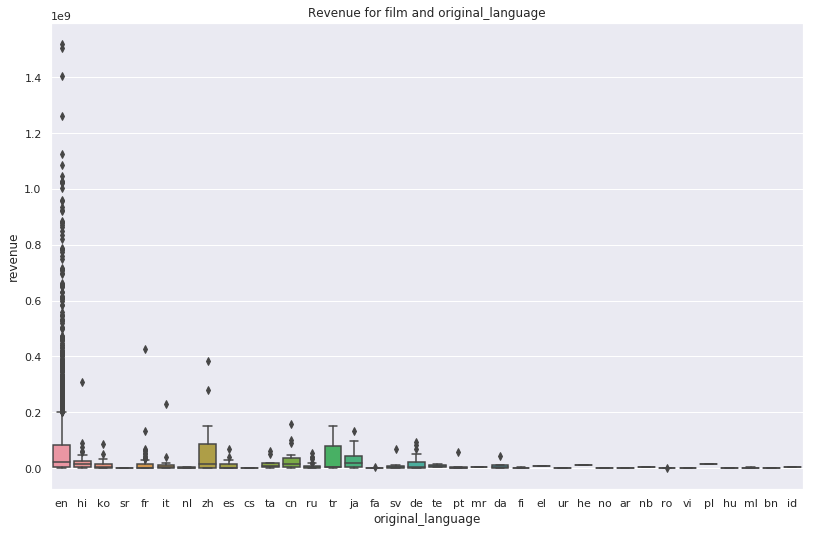

In [193]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='original_language', y='revenue', data=train_df)
plt.title('Revenue for a movie and its and original_language')

#### production country and revenue

1    2277
2     525
3     116
4      57
5      21
6       3
8       1
Name: num_of_production_countries, dtype: int64


Text(0.5, 1.0, 'number of production countries and movie revenues')

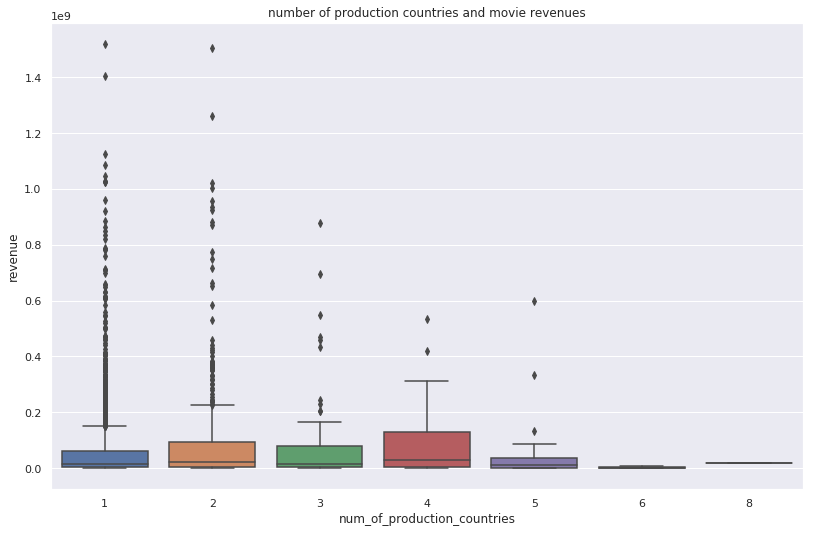

In [213]:
train_df["num_of_production_countries"] = train_df.production_countries_processed.apply(len)
print(train_df["num_of_production_countries"].value_counts())

sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='num_of_production_countries', y='revenue', data=train_df)
plt.title('number of production countries for a movie and revenue')

#### Day of the week when the movie released and revenue

Text(0.5, 1.0, 'day_of_week when the movie release and revenue')

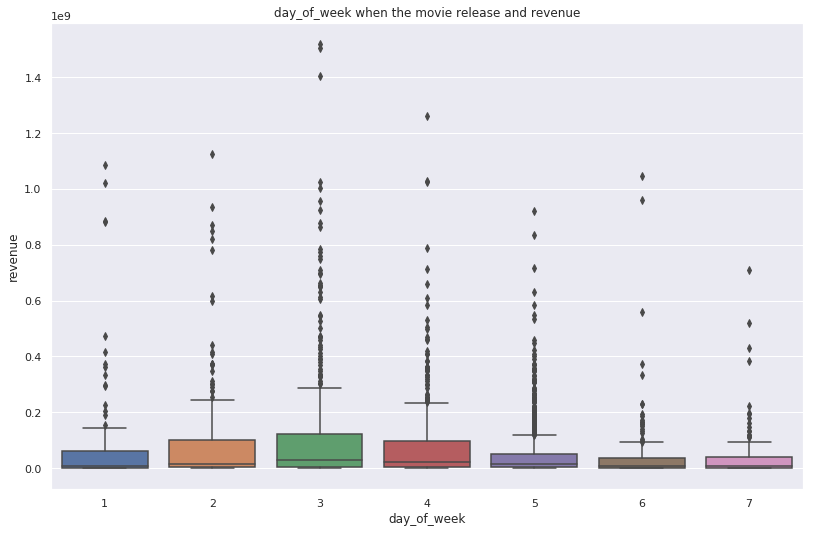

In [195]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='day_of_week', y='revenue', data=train_df)
plt.title('day_of_week when the movie release and revenue')

#### Month when the movie released and revenue

Text(0.5, 1.0, 'month when the movie release and revenue')

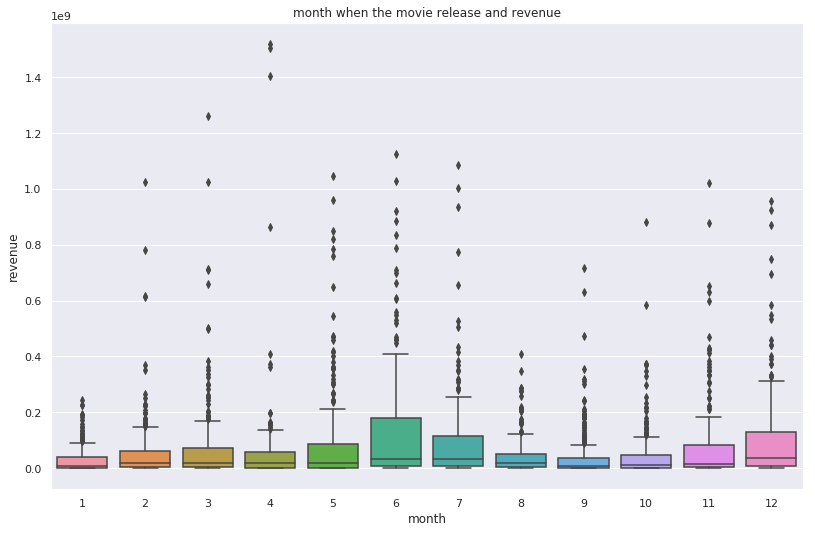

In [196]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.boxplot(x='month', y='revenue', data=train_df)
plt.title('month when the movie release and revenue')

#### Year when the movie released and revenue

Text(0.5, 1.0, 'Year when the movie release and revenue')

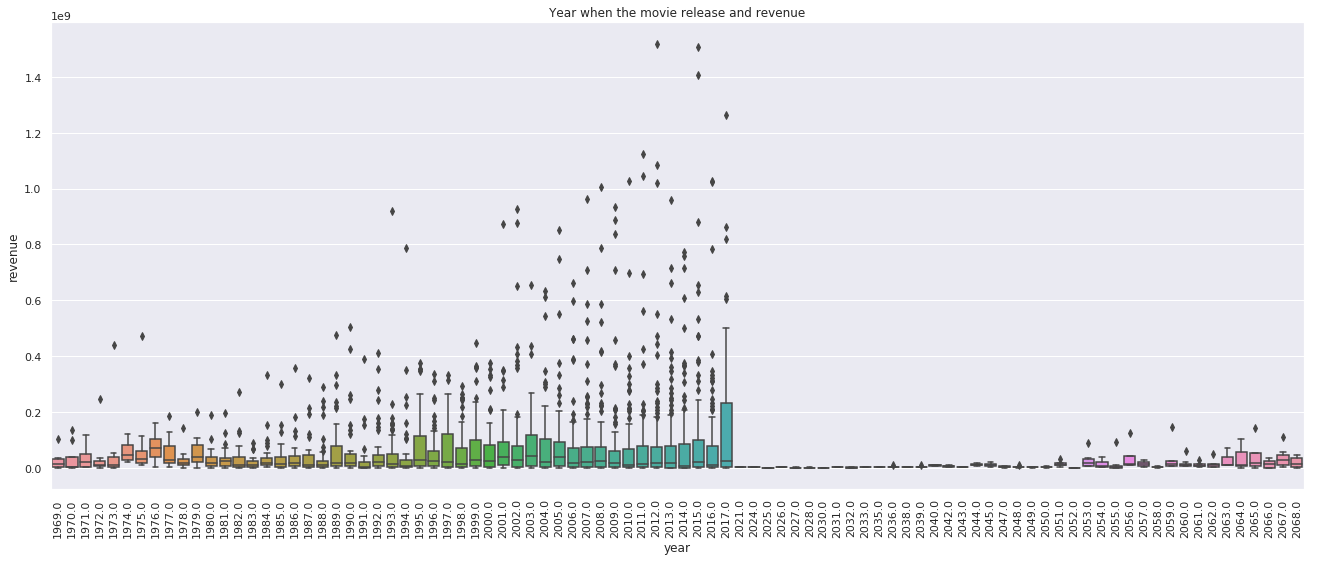

In [212]:
sns.set(rc={'figure.figsize':(20, 8)})
g = sns.boxplot(x='year', y='revenue', data=train_df)
plt.xticks(rotation=90)
plt.title('Year when the movie release and revenue')

## Machine Learning

![](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)
[image-source](https://cmci.colorado.edu/classes/INFO-4604/fa17/wordcloud.png)

#### Preparations before ML modeling

In [198]:
train_df.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'log_revenue', 'log_budget', 'genres_processed', 'num_genres',
       'isGenre_Drama', 'isGenre_Comedy', 'isGenre_Thriller', 'isGenre_Action',
       'isGenre_Romance', 'isGenre_Crime', 'isGenre_Adventure',
       'isGenre_Horror', 'isGenre_ScienceFiction', 'isGenre_Family',
       'isGenre_Fantasy', 'isGenre_Mystery', 'isGenre_Animation',
       'isGenre_History', 'isGenre_War', 'isGenre_Music',
       'isGenre_Documentary', 'isGenre_Western', 'isGenre_Foreign',
       'isGenre_TVMovie', 'production_companies_processed',
       'production_countries_processed', 'log_popularity', 'log_runtime',
       'month', 'year', 'day_of_week',

In [199]:
columns_for_training = ["log_budget", "log_popularity", "runtime", "day_of_week", "year", "month", "num_genres", "num_of_production_countries", "has_collection", "has_homepage", "original_language", 'isGenre_Action',
       'isGenre_Romance', 'isGenre_Crime', 'isGenre_Adventure',
       'isGenre_Horror', 'isGenre_ScienceFiction', 'isGenre_Family',
       'isGenre_Fantasy', 'isGenre_Mystery', 'isGenre_Animation',
       'isGenre_History', 'isGenre_War', 'isGenre_Music',
       'isGenre_Documentary', 'isGenre_Western', 'isGenre_Foreign',
       'isGenre_TVMovie']

#### One Hot Encoding for the feature original_language

In [200]:
from sklearn.preprocessing import LabelEncoder

#for col in ["original_language"]:
#    le=LabelEncoder()
#    le.fit(list(train_df[col].fillna('')) + list(test_df[col].fillna('')))
#    train_df[col] = le.transform(train_df[col].fillna('').astype(str))
#    test_df[col] = le.transform(test_df[col].fillna('').astype(str))


#gc.collect();

train_and_test = pd.concat([train_df, test_df], axis=0)
train_and_test = pd.concat([train_and_test, pd.get_dummies(train_and_test.original_language, prefix="original_language")], axis=1)
columns_for_training = columns_for_training + list(pd.get_dummies(train_and_test.original_language, prefix="original_language").columns.values)
train_df = train_and_test[~pd.isnull(train_and_test.revenue)]
test_df = train_and_test[pd.isnull(train_and_test.revenue)]

In [201]:
train_df[columns_for_training].head(4)

,log_budget,log_popularity,runtime,day_of_week,year,month,num_genres,num_of_production_countries,has_collection,has_homepage,original_language,isGenre_Action,isGenre_Romance,isGenre_Crime,isGenre_Adventure,isGenre_Horror,isGenre_ScienceFiction,isGenre_Family,isGenre_Fantasy,isGenre_Mystery,isGenre_Animation,isGenre_History,isGenre_War,isGenre_Music,isGenre_Documentary,isGenre_Western,isGenre_Foreign,isGenre_TVMovie,original_language_af,original_language_ar,original_language_bm,original_language_bn,original_language_ca,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,original_language_fa,original_language_fi,original_language_fr,original_language_he,original_language_hi,original_language_hu,original_language_id,original_language_is,original_language_it,original_language_ja,original_language_ka,original_language_kn,original_language_ko,original_language_ml,original_language_mr,original_language_nb,original_language_nl,original_language_no,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tr,original_language_ur,original_language_vi,original_language_xx,original_language_zh
0,16.454568,2.024905,93.0,5.0,2015.0,2.0,1,1.0,1,0,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,17.504390,2.224504,113.0,5.0,2004.0,8.0,4,1.0,1,0,en,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15.009433,4.178992,105.0,5.0,2014.0,10.0,1,1.0,0,1,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,13.997833,1.429099,122.0,5.0,2012.0,3.0,2,1.0,0,1,hi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [202]:
columns_for_training.remove("original_language")

In [203]:
y = train_df['log_revenue']
X = train_df[columns_for_training]

#### A function to calculate Root Mean Squared Logarithmic Error (RMSLE)

In [204]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

### Baseline XGBoost


Fold: 0

[0]	validation_0-rmse:14.1952	validation_1-rmse:14.1288
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[100]	validation_0-rmse:1.84891	validation_1-rmse:1.96976
[200]	validation_0-rmse:1.68367	validation_1-rmse:1.95615
[300]	validation_0-rmse:1.54127	validation_1-rmse:1.96807
[400]	validation_0-rmse:1.44039	validation_1-rmse:1.96244
[500]	validation_0-rmse:1.34596	validation_1-rmse:1.9526
[600]	validation_0-rmse:1.25541	validation_1-rmse:1.95781
[700]	validation_0-rmse:1.17909	validation_1-rmse:1.96101
[800]	validation_0-rmse:1.11598	validation_1-rmse:1.97031
[900]	validation_0-rmse:1.05552	validation_1-rmse:1.97592
[1000]	validation_0-rmse:0.99758	validation_1-rmse:1.98664
[1100]	validation_0-rmse:0.944161	validation_1-rmse:2.00216
[1200]	validation_0-rmse:0.897259	validation_1-rmse:2.00997
[1300]	validation_0-rmse:0.844806	validation_1-rmse:2.02138
[1400]	valida

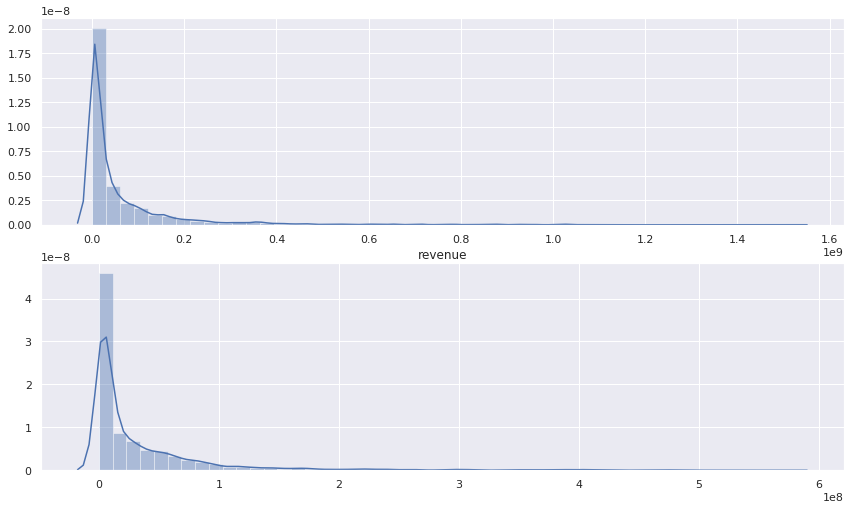

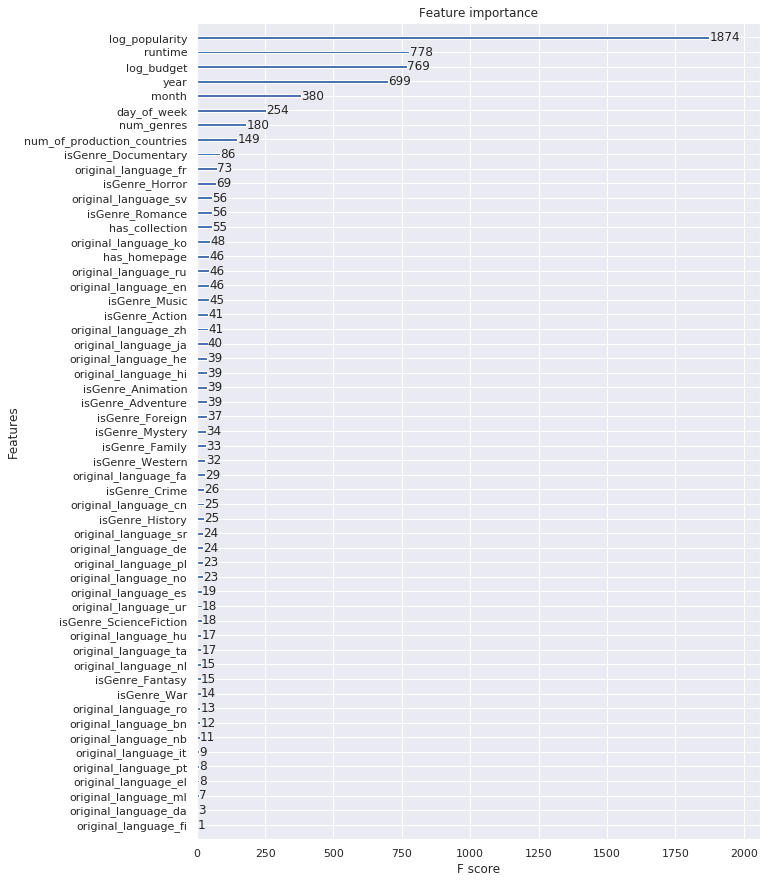

In [205]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error
import scikitplot as skplt
import time
import random

import xgboost as xgb

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

#predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test = np.zeros(len(test_df))
num_fold = 0
num_of_splits = 5
oof_rmse = 0
#feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=num_of_splits, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Fold:", num_fold)
    num_fold = num_fold + 1
    print()

    clf_stra_xgb = xgb.XGBRegressor(n_estimators=10000, seed=42, nthread=-1)

    clf_stra_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                early_stopping_rounds=1000, eval_metric='rmse', verbose=100)

    predictions_valid = clf_stra_xgb.predict(xvalid)
    rmse_valid = np.sqrt(mean_squared_error(yvalid, predictions_valid))
    oof_rmse += rmse_valid

    predictions_test += clf_stra_xgb.predict(test_df[xtrain.columns])/num_of_splits


predictions_test = np.expm1(predictions_test)
print(predictions_test)
print("OOF Out-of-fold rmse:", oof_rmse/num_of_splits)

f, ax = plt.subplots(2, figsize=(12,7))

f.tight_layout()
sns.set(rc={'figure.figsize':(9,14)})
sns.distplot(train_df.revenue, ax=ax[0])
sns.distplot(predictions_test, ax=ax[1])

xgb.plot_importance(clf_stra_xgb)

### Bayesian Tuning

In [206]:
def bayesian_tuning(xtrain, ytrain):
    
    from skopt import BayesSearchCV
    import xgboost as xgb
    
    
    # Classifier
    bayes_cv_tuner = BayesSearchCV(
        estimator = xgb.XGBRegressor(
            nthread = -1,
            objective = 'reg:linear',
            verbosity=1
        ),
        search_spaces = {
            'learning_rate': (0.01, 1.0),
            'min_child_weight': (0, 10),
            'n_estimators': (50, 100),
            'max_depth': (0, 12),
            'gamma': (1e-2, 10),
            'subsample': (0.01, 1.0),
            'colsample_bytree': (0.01, 1.0),
            'colsample_bylevel': (0.01, 1.0),
            'scale_pos_weight': (0.01, 1.0),
            'reg_lambda': (1e-1, 10),
            'reg_alpha': (1e-2, 1.0),
            'max_delta_step': (0, 10),
            'scale_pos_weight': (1e-2, 1)
        },
        cv = KFold(
            n_splits=num_of_splits,
            shuffle=True,
            random_state=42,
            nthread = -1
        ),
        n_jobs = 1,
        n_iter = 12,   
        verbose = 0,
        refit = True,
        random_state = 42
    )

    def status_print(optim_result):
        """Status callback durring bayesian hyperparameter search"""

        # Get all the models tested so far in DataFrame format
        all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    

        # Get current parameters and the best parameters    
        best_params = pd.Series(bayes_cv_tuner.best_params_)
        print('Model #{}\nBest score: {}\nBest params: {}\n'.format(
            len(all_models),
            np.round(bayes_cv_tuner.best_score_, 4),
            bayes_cv_tuner.best_params_
        ))
        
    result = bayes_cv_tuner.fit(xtrain, ytrain, callback = status_print)
    return result
    
# Fit the model
#xtrain, ytrain = prepare_for_tuning(X, y, type_of_training=type_of_training)
result = bayesian_tuning(xtrain, ytrain)

Model #1
Best score: 0.3804
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 9.32935130848986, 'learning_rate': 0.32264159755217825, 'max_delta_step': 7, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 87, 'reg_alpha': 0.31141867792614114, 'reg_lambda': 6.513136724634089, 'scale_pos_weight': 0.5544643023916863, 'subsample': 0.13556548021189216}

Model #2
Best score: 0.463
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 3.041066997742908, 'learning_rate': 0.9517116675273961, 'max_delta_step': 9, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 68, 'reg_alpha': 0.6393718108603786, 'reg_lambda': 9.539453486878958, 'scale_pos_weight': 0.6336020558163782, 'subsample': 0.9923710598637134}

Model #3
Best score: 0.463
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 3.041066997742908, 'learning_rate': 0.95171166752739

In [207]:
result.best_params_

{'colsample_bylevel': 0.7366877378057127,
 'colsample_bytree': 0.9399760402267441,
 'gamma': 1.644435714599117,
 'learning_rate': 0.19654103884777585,
 'max_delta_step': 8,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 77,
 'reg_alpha': 0.7874310977710708,
 'reg_lambda': 5.618529316013081,
 'scale_pos_weight': 0.5930070264428381,
 'subsample': 0.5689543694097536}

### Training after tuning


Fold: 0

[0]	validation_0-rmse:12.785	validation_1-rmse:12.7094
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[100]	validation_0-rmse:1.53789	validation_1-rmse:1.96986
[200]	validation_0-rmse:1.19699	validation_1-rmse:1.99771
[300]	validation_0-rmse:0.975018	validation_1-rmse:2.05507
[400]	validation_0-rmse:0.830527	validation_1-rmse:2.09901
[500]	validation_0-rmse:0.739209	validation_1-rmse:2.1358
[600]	validation_0-rmse:0.692976	validation_1-rmse:2.14878
[700]	validation_0-rmse:0.660463	validation_1-rmse:2.1601
[800]	validation_0-rmse:0.638798	validation_1-rmse:2.16502
[900]	validation_0-rmse:0.616572	validation_1-rmse:2.17465
[1000]	validation_0-rmse:0.60627	validation_1-rmse:2.17808
Stopping. Best iteration:
[65]	validation_0-rmse:1.70908	validation_1-rmse:1.94403


Fold: 1

[0]	validation_0-rmse:12.7544	validation_1-rmse:12.8315
Multiple eval metrics have been passed

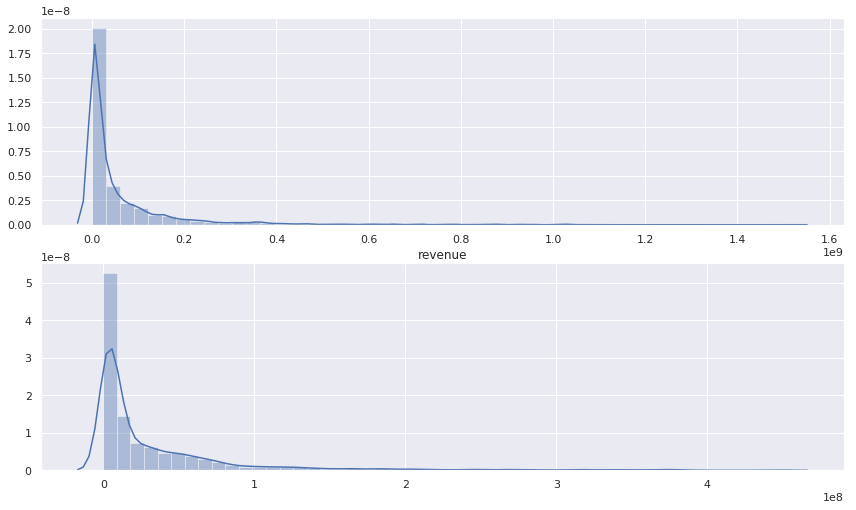

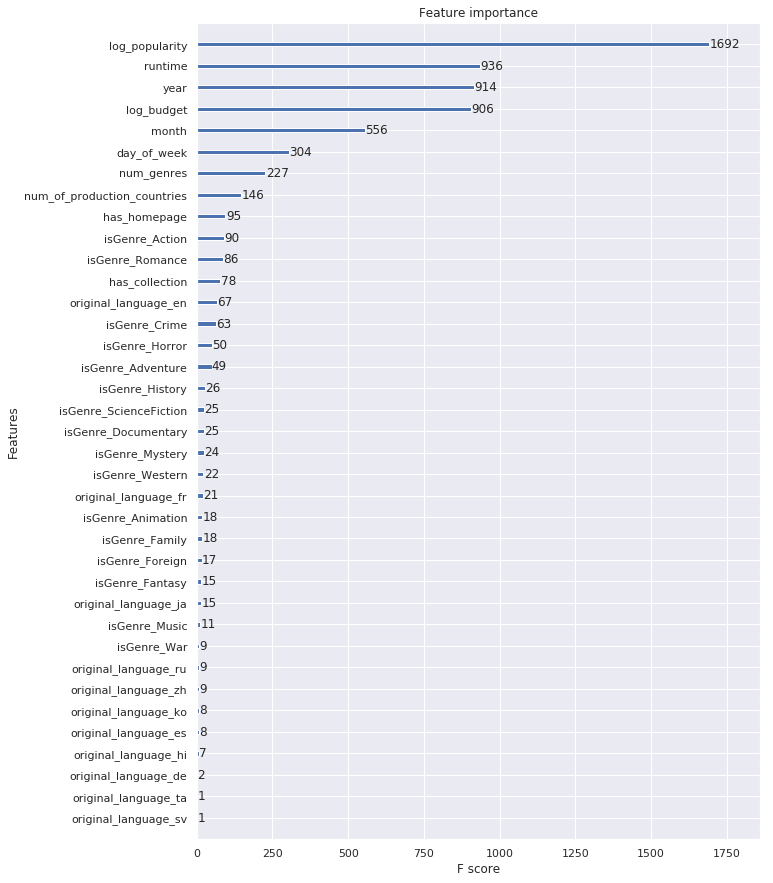

In [208]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import time
import random
from sklearn.metrics import mean_squared_error

import xgboost as xgb

# create a 70/30 stratified split of the data 
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=42, test_size=0.3)

import xgboost as xgb

start_time = time.time()

#predictions_probas_list = np.zeros([len(yvalid), 2])
predictions_test_tuned = np.zeros(len(test_df))
num_fold = 0
oof_rmse = 0
num_of_splits = 5
#feature_importance_df = pd.DataFrame()

folds = KFold(n_splits=num_of_splits, shuffle=False, random_state = 42)

for train_index, valid_index in folds.split(xtrain, ytrain):
    xtrain_stra, xvalid_stra = xtrain.iloc[train_index,:], xtrain.iloc[valid_index,:]
    ytrain_stra, yvalid_stra = ytrain.iloc[train_index], ytrain.iloc[valid_index]

    print()
    print("Fold:", num_fold)
    num_fold = num_fold + 1
    print()
    
    
    clf_stra_tuned_xgb = xgb.XGBRegressor(colsample_bytree = result.best_params_["colsample_bytree"],
                                    gamma=result.best_params_["gamma"],                 
                                    learning_rate=result.best_params_["learning_rate"],
                                    max_depth=result.best_params_["max_depth"],
                                    min_child_weight=result.best_params_["min_child_weight"],
                                    n_estimators=10000,
                                    reg_alpha=result.best_params_["reg_alpha"],
                                    reg_lambda=result.best_params_["reg_lambda"],
                                    subsample=result.best_params_["subsample"],
                                    seed=42,
                                    nthread = -1)

    clf_stra_tuned_xgb.fit(xtrain_stra, ytrain_stra, eval_set=[(xtrain_stra, ytrain_stra), (xvalid_stra, yvalid_stra)], 
                early_stopping_rounds=1000, eval_metric='rmse', verbose=100)

    predictions_valid = clf_stra_tuned_xgb.predict(xvalid)
    rmse_valid = np.sqrt(mean_squared_error(yvalid, predictions_valid))
    oof_rmse += rmse_valid

    predictions_test_tuned += clf_stra_tuned_xgb.predict(test_df[xtrain.columns])/num_of_splits
    

predictions_test_tuned = np.e**(predictions_test_tuned)-1
print(predictions_test_tuned)
print("OOF Out-of-fold rmse:", oof_rmse/num_of_splits)

f, ax = plt.subplots(2, figsize=(12,7))

f.tight_layout()
sns.set(rc={'figure.figsize':(9,14)})
sns.distplot(train_df.revenue, ax=ax[0])
sns.distplot(predictions_test_tuned, ax=ax[1])

xgb.plot_importance(clf_stra_tuned_xgb)

## Preparing for submission

In [209]:
gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['revenue'] = predictions_test
submission.to_csv('clf_xgb_baseline.csv', index=False)

gc.collect();
submission = pd.read_csv('../input/sample_submission.csv')
submission['revenue'] = predictions_test_tuned
submission.to_csv('clf_xgb_tuned.csv', index=False)